In [6]:
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
import multiprocessing as mp
from typing import Union


from abc import ABC
from epde.preprocessing.cheb import process_point_cheb

from epde.preprocessing.deriv_calculators import Heatmap, AbstractDeriv, AdaptiveFiniteDeriv, PolynomialDeriv, SpectralDeriv, TotalVariation




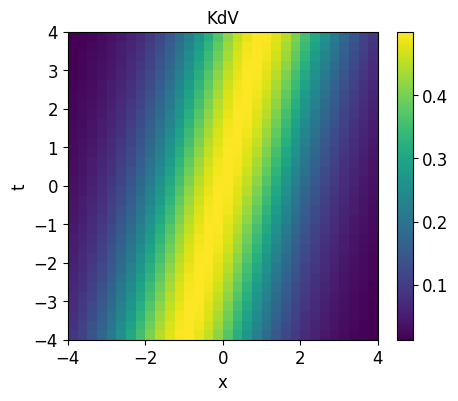

In [8]:
#kdv
data = np.load('data_kdv_noise0.npy')  
grid_x = np.linspace(-4, 4, 32)  
grid_t = np.linspace(-4, 4, 32)
x = np.linspace(-4, 4, 32)
t = np.linspace(-4, 4, 32)
plt.figure(figsize=(5, 4))
plt.imshow(data, aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('KdV')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [10]:
grid = [grid_x, grid_t]
print(data.shape)
print(len(grid))
print(grid)

derivative_calculator = SpectralDeriv()

derivatives = derivative_calculator.spectral_derivative_nd(data, grid, n=10, steepness=2)

#print('derivatives', derivatives)    
#print('derivatives[0]', derivatives[0])  
#print('derivatives[1]', derivatives[1])      
#print('len(derivatives)', len(derivatives))    
#print('len(derivatives[0])', len(derivatives[0]))    


X, Y = np.meshgrid(grid_x, grid_t)

plt.figure(figsize=(5, 4))
plt.imshow(derivatives[0], aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('data_x')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5, 4))
plt.imshow(derivatives[1], aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('data_t')
plt.xlabel('x')
plt.ylabel('t')
plt.show()


(32, 32)
2
[array([-4.        , -3.74193548, -3.48387097, -3.22580645, -2.96774194,
       -2.70967742, -2.4516129 , -2.19354839, -1.93548387, -1.67741935,
       -1.41935484, -1.16129032, -0.90322581, -0.64516129, -0.38709677,
       -0.12903226,  0.12903226,  0.38709677,  0.64516129,  0.90322581,
        1.16129032,  1.41935484,  1.67741935,  1.93548387,  2.19354839,
        2.4516129 ,  2.70967742,  2.96774194,  3.22580645,  3.48387097,
        3.74193548,  4.        ]), array([-4.        , -3.74193548, -3.48387097, -3.22580645, -2.96774194,
       -2.70967742, -2.4516129 , -2.19354839, -1.93548387, -1.67741935,
       -1.41935484, -1.16129032, -0.90322581, -0.64516129, -0.38709677,
       -0.12903226,  0.12903226,  0.38709677,  0.64516129,  0.90322581,
        1.16129032,  1.41935484,  1.67741935,  1.93548387,  2.19354839,
        2.4516129 ,  2.70967742,  2.96774194,  3.22580645,  3.48387097,
        3.74193548,  4.        ])]
freqs: [ 0.          0.12109375  0.2421875   0.3632812

ValueError: operands could not be broadcast together with shapes (32,) (2,) 

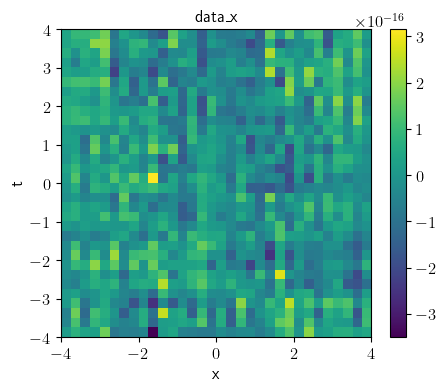

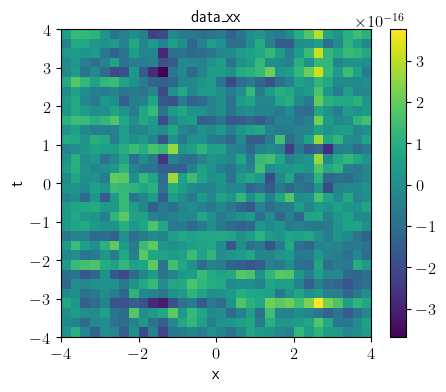

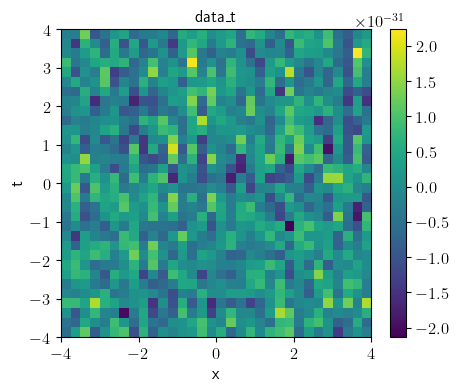

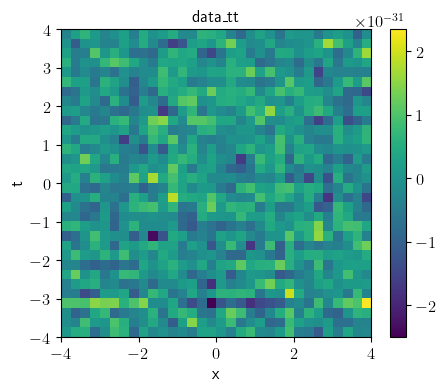

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class SpectralDeriv:
    @staticmethod
    def butterworth_filter(freqs, number_of_freqs, steepness):
        freqs_copy = np.copy(freqs)
        freqs_copy = np.abs(freqs_copy)
        freqs_copy.sort()
        if number_of_freqs > len(freqs_copy):
            number_of_freqs = len(freqs_copy)  #костыль на выход за границы 
        butterworth_filter_multiplier = 1 / \
            (1 + (freqs / freqs_copy[number_of_freqs - 1]) ** (2 * steepness))
        return butterworth_filter_multiplier

    def spectral_derivative_nd(self, func: np.ndarray, grid: list, n=None, steepness=1):
        if isinstance(n, int):
            n = np.full(shape=len(grid), fill_value=n)
        if n is None:
            n = np.min(func.shape)
        all_dim_derivative = []
        func_projection = np.fft.fftn(func, axes=[0, 1])

        for counter, i in enumerate(grid):
            spacing_vector = np.reshape(grid[counter], (1, grid[counter].size))
            frequencies = np.fft.fftfreq(spacing_vector.size, d=(spacing_vector[0][1] - spacing_vector[0][0]))
            frequencies_filtered = self.butterworth_filter(frequencies, n[counter], steepness)
            derivative = np.apply_along_axis(np.multiply, counter, func_projection, frequencies_filtered)
            derivative = np.real(np.fft.ifftn(derivative * 1j * 2 * np.pi))
            all_dim_derivative.append(derivative)
        return all_dim_derivative

spectral_deriv = SpectralDeriv()

first_derivatives = spectral_deriv.spectral_derivative_nd(data, [grid_x, grid_t], n=20, steepness=2)

second_derivatives = spectral_deriv.spectral_derivative_nd(first_derivatives[0], [grid_x, grid_t], n=20, steepness=2)

plt.figure(figsize=(5, 4))
plt.imshow(first_derivatives[0], aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('data_x')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5, 4))
plt.imshow(first_derivatives[1], aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('data_xx')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5, 4))
plt.imshow(second_derivatives[0], aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('data_t')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5, 4))
plt.imshow(second_derivatives[1], aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('data_tt')
plt.xlabel('x')
plt.ylabel('t')
plt.show()


(32, 32)
(32,)
(32,)
freqs: [0.         0.12109375 0.2421875  0.36328125 0.484375   0.60546875
 0.7265625  0.84765625 0.96875    1.08984375 1.2109375  1.33203125
 1.453125   1.57421875 1.6953125  1.81640625 1.9375    ]
freqs_copy: [0.         0.12109375 0.2421875  0.36328125 0.484375   0.60546875
 0.7265625  0.84765625 0.96875    1.08984375 1.2109375  1.33203125
 1.453125   1.57421875 1.6953125  1.81640625 1.9375    ]
number_of_freqs: 16
freqs: [0.         0.12109375 0.2421875  0.36328125 0.484375   0.60546875
 0.7265625  0.84765625 0.96875    1.08984375 1.2109375  1.33203125
 1.453125   1.57421875 1.6953125  1.81640625 1.9375    ]
freqs_copy: [0.         0.12109375 0.2421875  0.36328125 0.484375   0.60546875
 0.7265625  0.84765625 0.96875    1.08984375 1.2109375  1.33203125
 1.453125   1.57421875 1.6953125  1.81640625 1.9375    ]
number_of_freqs: 16
freqs: [0.         0.12109375 0.2421875  0.36328125 0.484375   0.60546875
 0.7265625  0.84765625 0.96875    1.08984375 1.2109375  1.33203

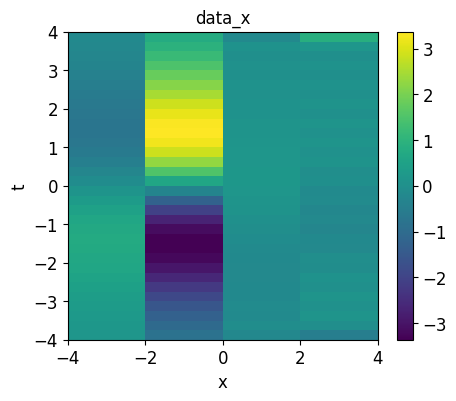

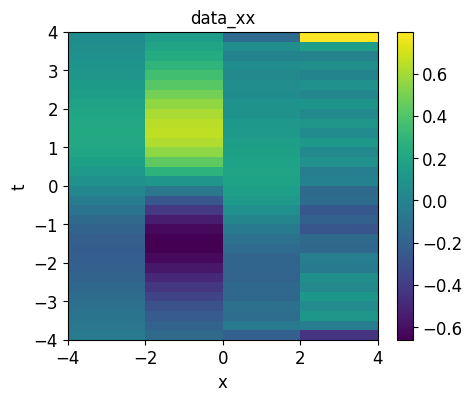

In [7]:
print(data.shape)
print(grid_x.shape)
print(grid_t.shape)
derivative_calculator = SpectralDeriv()

max_order = [2, 2]
mixed = False  
grid = [grid_x, grid_t]

#first_derivatives = derivative_calculator(data, grid, max_order = [2, 2])


derivatives = derivative_calculator(data, [grid_x, grid_t], max_order = [2, 2]).reshape(32, 32, 4)

#derivatives1 = derivative_calculator(derivatives[:, :, 1], [grid_x, grid_t], max_order = [2,2]).reshape(32, 32, 4)

X, Y = np.meshgrid(grid_x, grid_t)

plt.figure(figsize=(5, 4))
plt.imshow(derivatives[0], aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('data_x')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5, 4))
plt.imshow(derivatives[1], aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('data_xx')
plt.xlabel('x')
plt.ylabel('t')
plt.show()